In [1]:
### conflits with Deepnote ###

# matplotlib inline plotting
%matplotlib inline
# make inline plotting higher resolution
%config InlineBackend.figure_format = 'svg'

### conflits with Deepnote ###

In [2]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('dark_background')

In [3]:
df = pd.read_excel('Data.xlsx', sheet_name='cape', engine='openpyxl')

df = df.rename(columns={df.columns[0]: 'date'})
df = df[df.columns[:4]] # drop any cols above first 4
df['date'] = pd.to_datetime(df['date'], format=('%Y%m'))

df.head()

,date,ret,rf,cape
0,1926-07-01,0.0318,0.0022,11.869694
1,1926-08-01,0.0289,0.0025,12.488808
2,1926-09-01,0.0059,0.0023,12.692615
3,1926-10-01,-0.0292,0.0032,12.426518
4,1926-11-01,0.0284,0.0031,12.615251


## Problem 1, a)

The purpose of this problem is to analyze the predictive ability of the Cyclically Adjusted Price-Earnings (CAPE) ratio for future stock returns. The CAPE ratio is also known as the price-smoothed-earnings ratio or as the Shiller P/E ratio and the variable is available for free download at Robert Shillerís website. The CAPE ratio is defined as the real stock price divided by average real earnings over a ten-year period. It has been used in a series of articles by John Campbell and Robert Shiller to examine long-horizon stock market predictability.

Estimate long-horizon predictive regressions:

$$r_{t \rightarrow t+k}=\alpha_{k}+\beta_{k} x_{t}+\varepsilon_{t \rightarrow t+k}$$

where $r_{t \rightarrow t+k}$ is the log excess return on the US stock market from time $t$ to $t+k$ and $x_{t}$ is
the log CAPE ratio at time $t .^{1}$ Consider horizons in the range from one month up to ten years:
$k=1,6,12,24,36,48,60,72,84,96,108,$ and $120 .$ Report and compare the $\beta_{k}$ coefficients and
$R^{2}$ statistics across the forecast horizons. All necessary data to estimate (1) are available in the
excel file "Data.xlsx". The sample period is from 1926:m7 to 2020:m7.

In [4]:
k = [1, 6, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]

# reverse sorting the data
df = df.set_index('date')
df = df.sort_index(ascending=False)
df

,ret,rf,cape
date,,,
2020-07-01,0.0578,0.0001,29.610927
2020-06-01,0.0246,0.0001,28.843644
2020-05-01,0.0559,0.0001,27.329646
2020-04-01,0.1365,0.0000,25.927359
2020-03-01,-0.1327,0.0012,24.817169
...,...,...,...
1926-10-01,-0.0292,0.0032,12.426518
1926-09-01,0.0059,0.0023,12.692615
1926-08-01,0.0289,0.0025,12.488808


#### Log k-period returns

The $k$ -period log return is calculated as
$$
\begin{aligned}
r_{t \rightarrow t+k} &=\log \left(1+R_{t \rightarrow t+k}\right) \\
&=\log \left(1+R_{t+1}\right)+\log \left(1+R_{t+2}\right)+\ldots+\log \left(1+R_{t+k}\right) \\
&=r_{t+1}+r_{t+2}+\ldots+r_{t+k}
\end{aligned}
$$

In [5]:
# log-transforming CAPE
df['cape'] = np.log(df['cape'])

# generating k-period excess log-returns for 
df['ret'] = np.log(1 + df['ret'])
df['rf'] = np.log(1 + df['rf'])

for period in k:
    df[f'k={period}'] = df['ret'].rolling(period).sum() - df['rf'].rolling(period).sum()
    
# resording again
df = df.sort_index(ascending=True)

#### Lagging

We always lag the predictive variable in predictive regressions. Here we get $r_{t+1}=\alpha+\beta x_{t}+\varepsilon_{t+1}$ _(abstracting from the k-period returns notation)_. Thus we move the returns columns one period backwards.

In [6]:
# Lag all returns one period back-wards
df[df.columns[3:]] = df[df.columns[3:]].shift(-1)
df = df.dropna(how='all')
df

,ret,rf,cape,k=1,k=6,k=12,k=24,k=36,k=48,k=60,k=72,k=84,k=96,k=108,k=120
date,,,,,,,,,,,,,,,
1926-07-01,0.031305,0.002198,2.473988,0.025993,0.046851,0.192655,0.372093,0.709978,0.359452,-0.065708,-0.793039,-0.243071,-0.305186,-0.027681,0.339625
1926-08-01,0.028490,0.002497,2.524833,0.003585,0.061703,0.186116,0.410563,0.762309,0.336451,-0.087611,-0.503864,-0.155322,-0.276886,-0.027522,0.323481
1926-09-01,0.005883,0.002297,2.541020,-0.032830,0.059413,0.228937,0.435296,0.702673,0.196794,-0.435396,-0.537282,-0.271492,-0.282774,-0.005150,0.329647
1926-10-01,-0.029635,0.003195,2.519833,0.024909,0.096821,0.217823,0.481284,0.512011,0.137814,-0.325310,-0.645640,-0.325956,-0.266682,0.095612,0.431243
1926-11-01,0.028004,0.003095,2.534906,0.025791,0.124729,0.256510,0.567606,0.351362,0.082074,-0.445239,-0.731136,-0.255846,-0.211587,0.118341,0.438508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-01,-0.142370,0.001199,3.211536,0.127953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01,0.127953,0.000000,3.255299,0.054293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01,0.054393,0.000100,3.307972,0.024202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
res = []  # placeholder for results

for period in k:
    data = df[[f'k={period}', 'cape']].dropna(how='any')
    
    Y = data[f'k={period}']
    X = sm.add_constant(data['cape'])

    fit = sm.OLS(endog=Y, exog=X).fit()
    
    res.append({
        'horizon': period,
        'alpha': fit.params['const'],
        'beta': fit.params['cape'],
        'R2': fit.rsquared_adj * 100
    })

res = pd.DataFrame(res)
res

,horizon,alpha,beta,R2
0,1,0.032864,-0.009782,0.454831
1,6,0.205182,-0.061759,3.193525
2,12,0.446518,-0.136438,7.186357
3,24,0.863311,-0.263625,13.235476
4,36,1.171717,-0.353641,16.864028
5,48,1.410224,-0.419058,18.923008
6,60,1.585868,-0.460648,19.757823
7,72,1.695399,-0.475547,20.920020
8,84,1.878679,-0.516682,23.922550
9,96,2.127895,-0.583363,27.275441


#### Conclusion

As we see from the table above. The predictive power of CAPE increases when looking at longer return-horizons.

## Problem 1, b)

The use of overlapping data in (1) leads to autocorrelation in the error term. To address
this issue, we can use e.g. the Newey-West estimator to compute $t$ -statistics across the different
forecast horizons. To examine the effect of how standard errors are computed in long-horizon
regressions, try with two different lag-length specifications in the Newey-West estimator. First,
try to set the lag length in the Newey-West estimator equal to the forecast horizon and then
afterwards try with no lags in the Newey-West estimator.

In [8]:
res = []  # placeholder for results

for period in k:
    data = df[[f'k={period}', 'cape']].dropna(how='any')
    
    Y = data[f'k={period}']
    X = sm.add_constant(data['cape'])

    fit_nw_0 = sm.OLS(endog=Y, exog=X).fit(cov_type='HAC', cov_kwds={'maxlags': 0})
    fit_nw_k = sm.OLS(endog=Y, exog=X).fit(cov_type='HAC', cov_kwds={'maxlags': period})
    
    res.append({
        'horizon': period,
        'T-stat: NW (0 lags)': fit_nw_0.tvalues['cape'],
        'T-stat: NW (k lags)': fit_nw_k.tvalues['cape']
    })

res = pd.DataFrame(res)
res

,horizon,T-stat: NW (0 lags),T-stat: NW (k lags)
0,1,-2.028352,-1.831084
1,6,-5.952230,-3.040038
2,12,-9.257427,-3.423782
3,24,-12.989475,-3.283021
4,36,-13.784869,-3.066353
5,48,-16.111079,-3.209365
6,60,-18.894856,-3.537802
7,72,-20.524614,-3.580867
8,84,-22.790482,-3.486762
9,96,-23.624109,-3.462548


#### Conclusion

- When we don't lag our Newey-West std. errors we don't take into account serial correlation.
- Thus we get large (absolute) t-statistics when using 0-lags, however this has low power due to serial correlation. 
- $H_0:\; \beta_k=0$ can however be rejected as $k$ increases for the model with $k$ lags.
- The reason why $k$ lags is a relevant choice is that the overlap in returns implies that $\varepsilon_{t+k} \sim M A(k-1)$ by construction.

## Problem 1, c)

Similar to the price-dividend ratio, the CAPE ratio is highly persistent and slow to mean-
revert, implying that forecasts build up over time. Make two scatter plots where you plot the
time $t$ log CAPE ratio against the one-month ahead log excess return $\left(r_{t \rightarrow t+1}\right)$ and the ten-year
ahead log excess return $\left(r_{t \rightarrow t+120}\right),$ respectively.

Text(0.5, 1.0, 'CAPE vs. one month ahead excess returns')

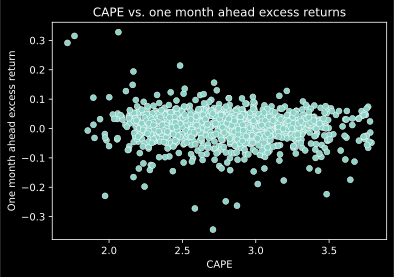

In [9]:
sns.scatterplot(x='cape', y='k=1', data=df)

plt.ylabel('One month ahead excess return')
plt.xlabel('CAPE')

plt.title('CAPE vs. one month ahead excess returns')

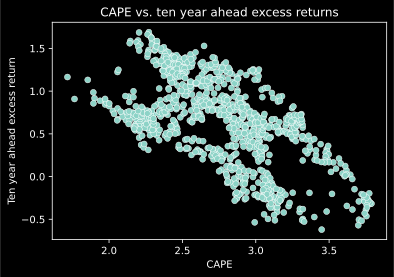

In [10]:
sns.scatterplot(x='cape', y='k=120', data=df)

plt.ylabel('Ten year ahead excess return')
plt.xlabel('CAPE')

plt.title('CAPE vs. ten year ahead excess returns')

plt.show()